# Eric Wilson HW #2 Extra Credit Submission

-------------------------------------------------------------------------------------

## ANSWER

The MLP model I trained in part_1 had 50,001 parameters (achieved a test performance of 45.3 MSE)

The CNN model I train below is only 2,913 parameters and acheives a test loss of 65.6 MSE.

In [10]:
%reset -f

### Defines StockDataset CLASS

In [11]:
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Returns data in "Flat" 1D format
class StockDataset(Dataset):
    def __init__(self,X,Y,days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days # days ahead for prediction

    def __len__(self):
        return (len(self.Y)-self.days)

    def __getitem__(self,index):
        x=self.X[:,index:index+self.days]
        x = x.flatten().astype(np.float32)  # returns flat data
        y=self.Y[index+self.days]
        return x,y


# Returns data in (Stock x Days) format
class StockDataset_Rect(StockDataset):
    def __init__(self, X, Y, days):
        super().__init__(X, Y, days)

    def __getitem__(self,index):
        x=self.X[:,index:index+self.days]
        x = x.astype(np.float32)            # returns (ticker x days)
        y=self.Y[index+self.days]
        return x,y

### Get Stock Data

In [12]:
# !pip install pandas
# !pip install yfinance
import numpy as np
from numpy import exp, sum, log, log10
import yfinance as yf
import pandas as pd

def get_price(tick,start='2020-01-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2020-01-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df


# Get Data
feature_stocks=['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock='msft'
start_date='2020-01-01'
allX=get_prices(feature_stocks,start=start_date)
ally=get_prices([predict_stock],start=start_date)


# Create different datasets
stockData = StockDataset(allX.to_numpy().transpose().astype(np.float32),ally.to_numpy().astype(np.float32),days=5)
stockData_deep = StockDataset_Rect(allX.to_numpy().transpose().astype(np.float32),ally.to_numpy().astype(np.float32),days=32)

### Define DataLoader

In [ ]:
import lightning as pl
import torch.utils.data as data
import torch



class Stock_DataLoader(pl.LightningDataModule):

    # LightningDataModule is just a WRAPPER for torch.DataLoader
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size


    # splits data into different data sets
    def split_data(self, all_data, frac_train, frac_validate):

        # Determine each dataset size
        self.train_set_size = int(len(all_data)*frac_train)
        self.valid_set_size = int(len(all_data)*frac_validate)
        self.test_set_size = len(all_data)-self.train_set_size - self.valid_set_size

        # Split Data
        self.train_set, self.val_set, self.test_set = data.random_split(all_data,[self.train_set_size, self.valid_set_size, self.test_set_size],\
                                              generator=torch.Generator().manual_seed(42))



    def train_dataloader(self):
        return data.DataLoader(self.train_set, batch_size=self.train_set_size, shuffle=True)  # training data will always be shuffled

    def val_dataloader(self):
        return data.DataLoader(self.val_set, batch_size=self.valid_set_size, shuffle=False)   # validation won't be shuffled
    

    def test_dataloader(self):
        return data.DataLoader(self.val_set, batch_size=self.test_set_size, shuffle=False)   # validation won't be shuffled


### Define CNN Class  (model trained with num_layer = 1, so 2,913 parameters)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as pl

class CNN_v1(pl.LightningModule):
    def __init__(self, in_channels=20, seq_len=32, dropout_rate=0.3, lr=5e-3, num_layer = 1):
        super().__init__()

        self.seq_len = seq_len
        self.lr = lr
        self.train_loss = []
        self.eval_loss = []
        self.test_loss = []

        self.k1 = 5
        self.k2 = 3
        self.k3 = 3

        # Allows users to choose between 3 different CNN topologies
        match num_layer:

            case 1:
                self.cnn = nn.Sequential(
                    nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=self.k1),  # 1st conv
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),

                    nn.Flatten(),
                    nn.Linear(32 * (seq_len - self.k1 + 1), 1)
                )
            
            case 2:
                self.cnn = nn.Sequential(
                    nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=self.k1),  # 1st conv
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),

                    nn.Conv1d(in_channels=32, out_channels=32, kernel_size=self.k2),  # 2nd conv layer
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),

                    nn.Flatten(),
                    nn.Linear(32 * (seq_len - self.k1 + 1 - self.k2 + 1), 1)
                )

            case 3:
                self.cnn = nn.Sequential(
                    nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=self.k1),  # 1st conv
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),

                    nn.Conv1d(in_channels=32, out_channels=32, kernel_size=self.k2),  # 2nd conv layer
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),

                    nn.Conv1d(in_channels=32, out_channels=32, kernel_size=self.k3),  # 3nd conv layer
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),

                    nn.Flatten(),
                    nn.Linear(32 * (seq_len - self.k1 + 1 - self.k2 + 1 - self.k3 + 1), 1)
                )




    def forward(self, x):
        return self.cnn(x)

    # RUNS MODEL INFERENCE, COMPUTES LOSS, SAVES LOSS (training)
    def training_step(self, batch, batch_idx):
        x, y = batch                            # sets training inputs (x), and outputs (y)
        y_hat = self(x)                         # runs inference and saves results
        loss = F.mse_loss(y_hat.squeeze(), y)   # computes loss
        self.train_loss.append( loss.item() )   # save training loss
        # print(" -- train step")
        return loss

    # RUNS MODEL INFERENCE, COMPUTES LOSS, SAVES LOSS (validation)
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.mse_loss(y_hat.squeeze(), y)
        self.eval_loss.append( val_loss.item() )
        self.log("val_loss", val_loss, prog_bar=True, on_epoch=True)
        # print(" --------------- eval step")
        return val_loss

    # RUNS MODEL INFERENCE, COMPUTES LOSS, SAVES LOSS (test)
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = F.mse_loss(y_hat.squeeze(), y)
        self.test_loss.append( test_loss.item() )
        return test_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

### Train CNN Model


In [16]:
import lightning as pl
import torch

# Instantiate DataLoaders
CNN_dataLoader = Stock_DataLoader(batch_size=32*20)
CNN_dataLoader.split_data(stockData_deep, frac_train=0.7, frac_validate=0.15)


# Make the model
CNN_L1 = CNN_v1(in_channels=20, seq_len=32, dropout_rate=0.15, lr=1.5e-4, num_layer=1)

# Instantiate Trainer
CNN_trainer_L1 = pl.Trainer( max_epochs=5000, check_val_every_n_epoch=1 )

# Train Model
CNN_trainer_L1.fit( CNN_L1, datamodule=CNN_dataLoader )

# Test Model
CNN_trainer_L1.test( CNN_L1, datamodule=CNN_dataLoader )

# Save Model Weights
torch.save(CNN_L1.state_dict(), "cnn_weights.pt")

print("done")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | cnn  | Sequential | 4.1 K  | train
--------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


c:\Users\ericw\Desktop\OU\Spring_25\Machine_Learning\HW\HW_2\HW_2_local\myEnv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\ericw\Desktop\OU\Spring_25\Machine_Learning\HW\HW_2\HW_2_local\myEnv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\ericw\Desktop\OU\Spring_25\Machine_Learning\HW\HW_2\HW_2_local\myEnv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you

Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s, v_num=104, val_loss=60.80] 

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s, v_num=104, val_loss=60.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ericw\Desktop\OU\Spring_25\Machine_Learning\HW\HW_2\HW_2_local\myEnv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]
done


### Plot Learning Curves

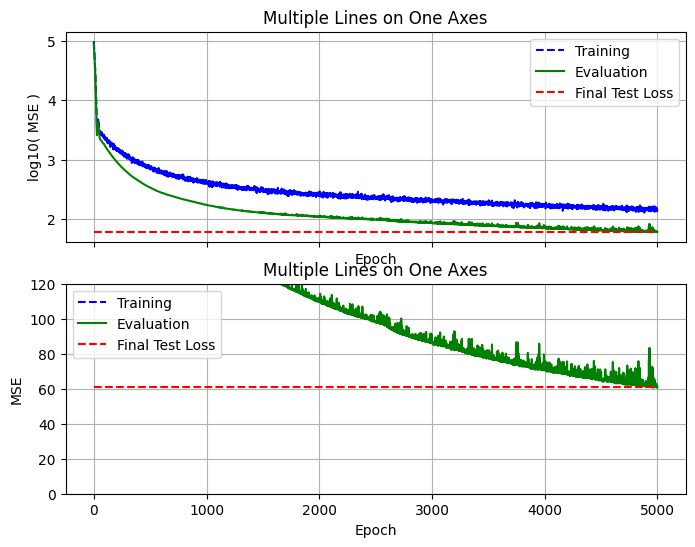

Final Test Loss = 60.840972900390625


In [17]:
import matplotlib.pyplot as plt


# Create figure and a single axes
fig_mse, (ax_log_mse, ax_mse) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)


# Compute Plotting Data
x_epoch = np.arange(0, CNN_L1.current_epoch)

train_loss_lin = CNN_L1.train_loss
eval_loss_lin = CNN_L1.eval_loss[1:]
test_loss_lin = CNN_L1.test_loss[0]

train_loss_log = np.log10( train_loss_lin )
eval_loss_log = np.log10( eval_loss_lin )
test_loss_log = np.log10( test_loss_lin )

# ------------------
# Log Axes
ax_log_mse.plot( x_epoch, train_loss_log, label="Training", color='blue', linestyle='--')
ax_log_mse.plot( x_epoch, eval_loss_log, label="Evaluation", color='green', linestyle='-')
ax_log_mse.plot( [0, CNN_L1.current_epoch], [test_loss_log, test_loss_log], label="Final Test Loss", color='red', linestyle='--')

ax_log_mse.set_xlabel("Epoch")
ax_log_mse.set_ylabel("log10( MSE )")
ax_log_mse.set_title("Multiple Lines on One Axes")
ax_log_mse.grid(True)
ax_log_mse.legend()

# ------------------
# Linear Axes
ax_mse.plot( x_epoch, train_loss_lin, label="Training", color='blue', linestyle='--')
ax_mse.plot( x_epoch, eval_loss_lin, label="Evaluation", color='green', linestyle='-')
ax_mse.plot( [0, CNN_L1.current_epoch], [test_loss_lin, test_loss_lin], label="Final Test Loss", color='red', linestyle='--')


ax_mse.set_ylim(0,120)
ax_mse.set_xlabel("Epoch")
ax_mse.set_ylabel("MSE")
ax_mse.set_title("Multiple Lines on One Axes")
ax_mse.grid(True)
ax_mse.legend()

# Set labels and title
ax_mse.set_xlabel("Epoch")
ax_mse.set_ylabel("MSE")
ax_mse.set_title("Multiple Lines on One Axes")



# Show plot
plt.show()

print(f"Final Test Loss = {test_loss_lin}")

#### NOTICE: The CNN L1 model achieved MSE = 60.8! (below the 120 threshold mentioned in extra credit)

# I am not using test data for hyperparameter tuning as specified in HW assignment